In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# A simple regression problem

## Data generation

In [2]:
def generate_without_missing_values(n_samples):
    mean = [0, 0]
    cov = [[1, 0.5], [0.5, 1]]
    X = np.random.multivariate_normal(mean, cov, size=n_samples)
    
    epsilon = 0.1 * np.random.randn(n_samples)
    y = X[:, 0] + epsilon
    
    return X, y

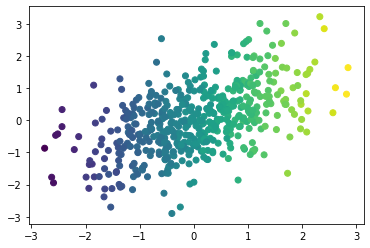

In [3]:
X, y = generate_without_missing_values(500)
plt.scatter(X[:, 0], X[:, 1], c=y);

## Model evaluation

In [4]:
from sklearn.model_selection import learning_curve


def plot_learning_curve_without_missing_values(estimator):
    X, y = generate_without_missing_values(10 ** 7)
    sizes = np.logspace(2, 4, 5).astype(int)
    
    train_sizes, _, valid_scores = learning_curve(
        estimator, X, y, train_sizes=sizes, scoring='r2', cv=30, random_state=0)

    plt.plot(train_sizes, np.median(valid_scores, axis=1))
    plt.fill_between(train_sizes,
        np.percentile(valid_scores, q=25, axis=1),
        np.percentile(valid_scores, q=75, axis=1), alpha=0.2)
    
    plt.xscale('log')
    plt.xlabel('Sample size')
    plt.ylabel('r2 score') 
    plt.xlim(train_sizes.min(), train_sizes.max())

CPU times: user 13.1 s, sys: 1.48 s, total: 14.6 s
Wall time: 7.88 s


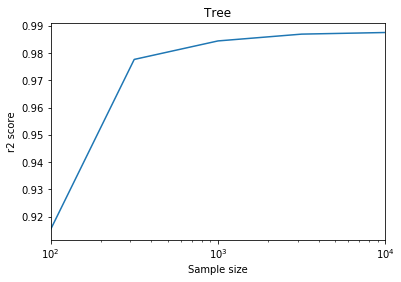

<Figure size 432x288 with 0 Axes>

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

tree = DecisionTreeRegressor(min_samples_leaf=10)
boosting = HistGradientBoostingRegressor()

%time plot_learning_curve_without_missing_values(tree)
plt.title("Tree");
plt.show()
plt.clf()
#plot_learning_curve_without_missing_values(boosting)
#plt.title("Boosting");
#plt.show()
#plt.clf()

# Now with missing values

## Data generation: different mechanisms

In [6]:
def generate(n_samples, mechanism):
    X, y = generate_without_missing_values(n_samples)
    
    if mechanism == 'mcar':
        missing_rate = 0.2
        M = np.random.binomial(1, missing_rate, (n_samples, 2))
    elif mechanism == 'censored':
        M = (X > 0.5)
    
    np.putmask(X, M, np.nan)
    
    return X, y

## Different models to try

In [7]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, MissingIndicator
from sklearn.pipeline import Pipeline, make_union

tree_with_mean_imputation = Pipeline([
    ('Mean imputation', SimpleImputer(strategy='mean')), 
    ('Tree', DecisionTreeRegressor(min_samples_leaf=10))
])   
tree_with_iterative_imputation = Pipeline([
    ('Iterative imputation', IterativeImputer()), 
    ('Tree', DecisionTreeRegressor(min_samples_leaf=10))
])
tree_with_mean_imputation_and_mask = Pipeline([
    ('Mean imputation and mask', make_union(SimpleImputer(strategy='mean'), MissingIndicator())), 
    ('Tree', DecisionTreeRegressor(min_samples_leaf=10))
])   
tree_with_iterative_imputation_and_mask = Pipeline([
    ('Iterative imputation and mask', make_union(IterativeImputer(), MissingIndicator())), 
    ('Tree', DecisionTreeRegressor(min_samples_leaf=10))
])

trees = {
    'Mean': tree_with_mean_imputation,
    'Iterative': tree_with_iterative_imputation,
    'Mean + mask': tree_with_mean_imputation_and_mask,
    'Iterative + mask': tree_with_iterative_imputation_and_mask
}

boosting_with_mean_imputation = Pipeline([
    ('Mean imputation', SimpleImputer(strategy='mean')), 
    ('Boosting', HistGradientBoostingRegressor())
])   
boosting_with_iterative_imputation = Pipeline([
    ('Iterative imputation', IterativeImputer()), 
    ('Boosting', HistGradientBoostingRegressor())
])
boosting_with_mean_imputation_and_mask = Pipeline([
    ('Mean imputation and mask', make_union(SimpleImputer(strategy='mean'), MissingIndicator())), 
    ('Boosting', HistGradientBoostingRegressor())
])   
boosting_with_iterative_imputation_and_mask = Pipeline([
    ('Iterative imputation and mask', make_union(IterativeImputer(), MissingIndicator())), 
    ('Boosting', HistGradientBoostingRegressor())
])

boostings = {
    'Mean': boosting_with_mean_imputation,
    'Iterative': boosting_with_iterative_imputation,
    'Mean+mask': boosting_with_mean_imputation_and_mask,
    'Iterative+mask': boosting_with_iterative_imputation_and_mask
}

## Model evaluation

In [8]:
def plot_learning_curve(estimators, mechanism):
    X, y = generate(10 ** 7, mechanism)
    sizes = np.logspace(2, 4, 5).astype(int)
    
    for key, est in estimators.items():
        train_sizes, _, valid_scores = learning_curve(
            est, X, y, train_sizes=sizes, scoring='r2', cv=30, random_state=0)
        
        plt.plot(train_sizes, np.median(valid_scores, axis=1), label=key)
        plt.fill_between(train_sizes,
            np.percentile(valid_scores, q=25, axis=1),
            np.percentile(valid_scores, q=75, axis=1), alpha=0.2)
    
    plt.xscale('log')
    plt.legend()
    plt.xlabel('Sample size')
    plt.ylabel('r2 score') 
    plt.xlim(train_sizes.min(), train_sizes.max())
    

def boxplot_scores(estimators, n_samples, mechanism):
    # one slice of the learning curve
    X, y = generate(10 ** 6, mechanism)
    
    scores = {}
    for key, est in estimators.items():
        scores[key] = learning_curve(
            est, X, y, train_sizes=[n_samples], scoring='r2', cv=30, random_state=0)[2][0]
    
    plt.boxplot(scores.values(), labels=scores.keys(), vert=False)
    plt.title('{}, sample size: {}'.format(mechanism, n_samples))
    plt.xlabel('r2 score')

In [ ]:
%time plot_learning_curve(trees, 'mcar')

In [ ]:
boxplot_scores(trees, 500, 'mcar')

In [ ]:
%time plot_learning_curve(trees, 'censored')

In [ ]:
boxplot_scores(trees, 500, 'censored')

In [ ]:
%time plot_learning_curve(boostings, 'mcar')

In [ ]:
boxplot_scores(boostings, 500, 'mcar')

In [ ]:
%time plot_learning_curve(boostings, 'censored')

In [ ]:
boxplot_scores(boostings, 500, 'censored')